In [97]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import script
import pandas as pd
import tqdm.notebook as tqdm
from multiprocessing import Pool
import seaborn as sns
import subprocess
import os
import pickle
import json 

def save_runs(exp_root, exp_name, runs, args):
    git_hash = script.get_git_revision_hash()
    dirty = b'script.py' in subprocess.check_output(['git', 'diff', '--name-only'])
    exp_root = os.path.join(exp_root, f'{git_hash}-dirty' if dirty else f'{git_hash}')
    exp_dir = os.path.join(exp_root, exp_name)
    os.makedirs(exp_dir)
    with open(os.path.join(exp_dir, 'results'), 'wb') as f:
        pickle.dump(runs, f)
    with open(os.path.join(exp_dir, 'args' ), 'w') as f:
        json.dump(vars(args), f, indent=True, sort_keys=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## harris et. al setup with selection

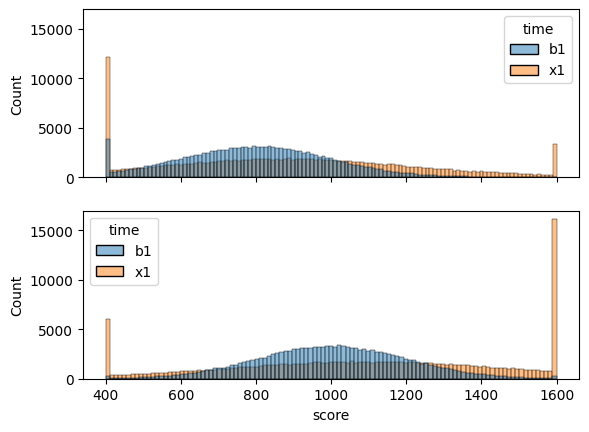

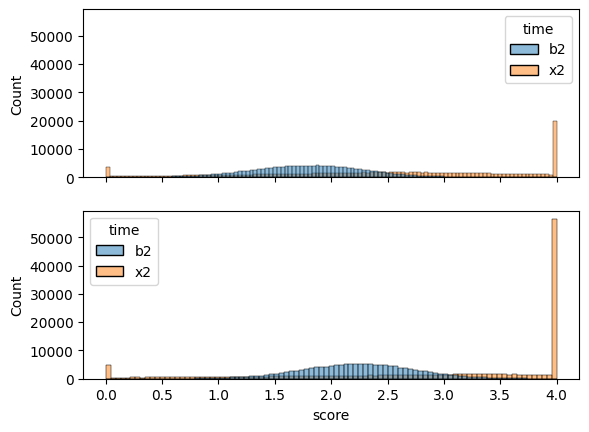

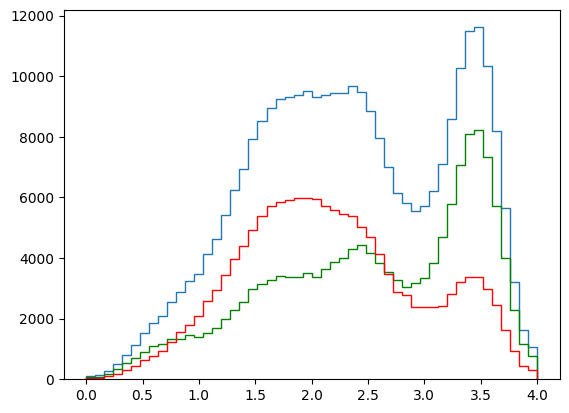

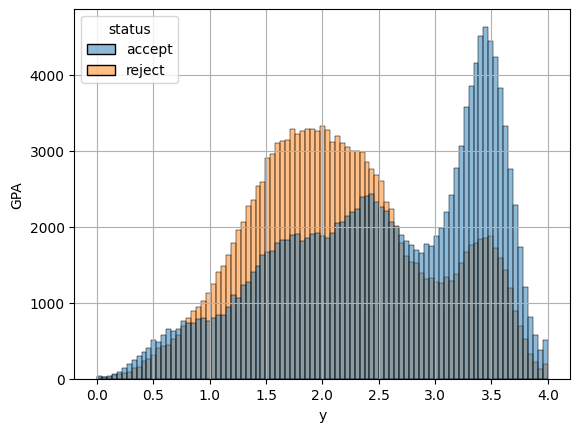

In [98]:
# plot data.
cmd =f'--num-applicants 300000 --applicants-per-round 1000 --clip'
args = script.get_args(cmd)
np.random.seed(1)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = script.generate_data(
    args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args
    )

df0 = pd.DataFrame(
    {'b1': b[disadv_idx,0], 'b2': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     'x1': x[disadv_idx,0], 'x2': x[disadv_idx,1]},
)
df1 = pd.DataFrame(
    {'b1': b[adv_idx,0], 'b2': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx], 'x1': x[adv_idx, 0], 'x2': x[adv_idx, 1], 'y_hat': y_hat[0, disadv_idx]},
)
df0['class'] = 'disadv'
df1['class'] = 'adv'
df = pd.concat((df0, df1))
df
dflong = pd.melt(df, id_vars=('class'), value_vars=('b1', 'x1'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])

dflong = pd.melt(df, id_vars=('class'), value_vars=('b2', 'x2'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])
# fig,ax=plt.subplots()
# sns.histplot(df,x='y_hat',ax=ax)
# sns.histplot(df[df.status==1], x='y_hat', ax=ax)

fig,ax=plt.subplots()
plt.hist(y[0],  histtype='step', bins=50)
plt.hist(y[0][z==1],  histtype='step', color='g', bins=50)
plt.hist(y[0][z==0], histtype='step', color='r', bins=50)

dfa, dfr = pd.DataFrame({'y': y[0][z==1]}), pd.DataFrame({'y': y[0][z==0]})
dfa['status'] = 'accept'
dfr['status'] = 'reject'
df = pd.concat((dfa, dfr))
fig,ax=plt.subplots()
sns.histplot(df, x='y', hue='status', ax=ax)
ax.set_ylabel('GPA')
ax.grid()

# sns.histplot(df, x='y', ax=ax)

In [99]:
n_runs = 10
cmd =f'--num-applicants 300000 --applicants-per-round 1000 --clip --methods ols 2sls --stream'
args = script.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(script.run_multi_env, args_list )

299it [00:05, 49.92it/s] 
299it [00:06, 49.42it/s]
299it [00:05, 50.08it/s]
299it [00:05, 50.49it/s]
299it [00:06, 49.65it/s]
299it [00:05, 51.75it/s]
299it [00:06, 49.66it/s]
299it [00:06, 49.49it/s]
299it [00:06, 48.03it/s]
299it [00:06, 49.82it/s]


In [102]:
save_runs('experiments', 'harris-with-selection', runs, args)
#with open('/home/maadil/strategic-iv/experiments/38f2b2def647847bd85caa97013d0f522014871e/harris-with-selection/results', 'rb') as f:
    #runs = pickle.load(f)
# runs
# with open('/home/maadil/strategic-iv/experiments/f711f06/harris-with-selection/results', 'rb') as f:
    # runs = pickle.load(f)
# runs 

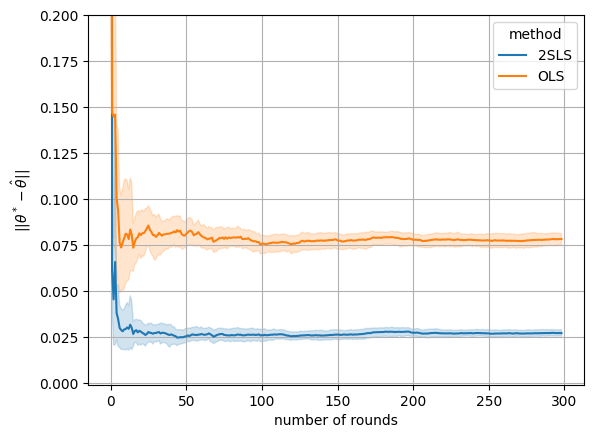

In [101]:
# converting to long format.
df = script.runs2df(runs)
dflong = pd.melt(df, id_vars='iterations', value_vars=('ols_env0', '2sls_env0'), var_name='method', value_name='error')
dflong['method'] = dflong['method'].astype('category')
dflong['method']= dflong['method'].cat.rename_categories({'ols_env0':'OLS', '2sls_env0': '2SLS'})

# plot
fig,ax=plt.subplots()
sns.lineplot(data=dflong, x='iterations', y='error', hue='method', ax=ax)
ax.set_ylim(bottom=-0.001, top=0.2)
ax.set_ylabel(r'$||\theta^* - \hat{\theta}|| $')
ax.set_xlabel('number of rounds')
ax.grid()

## our setup.

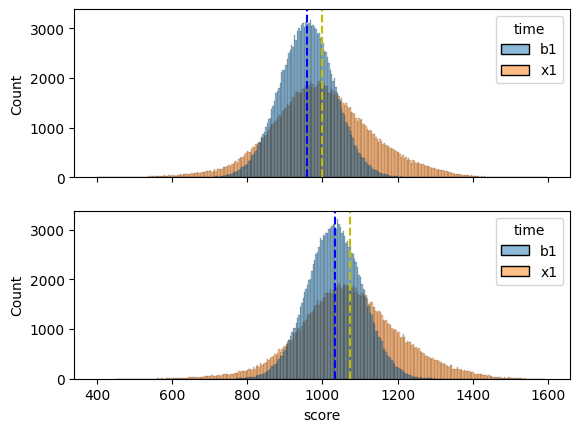

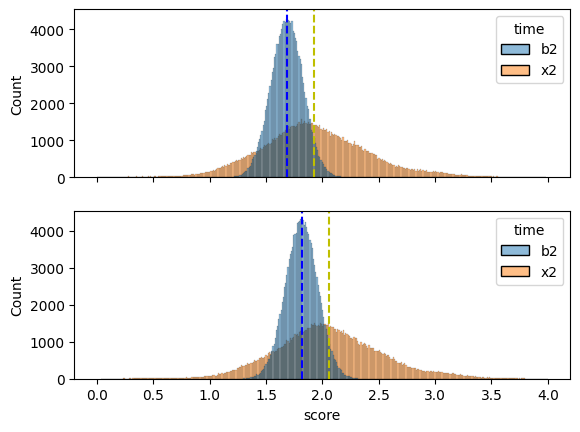

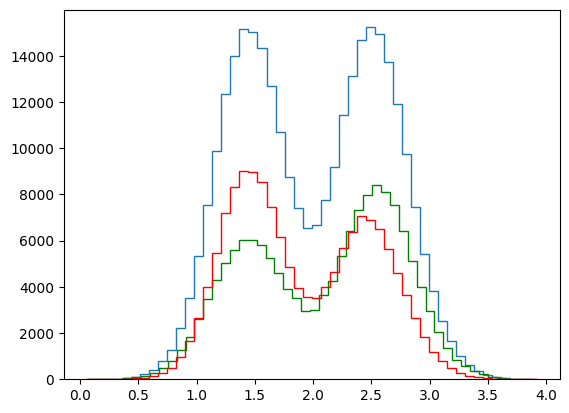

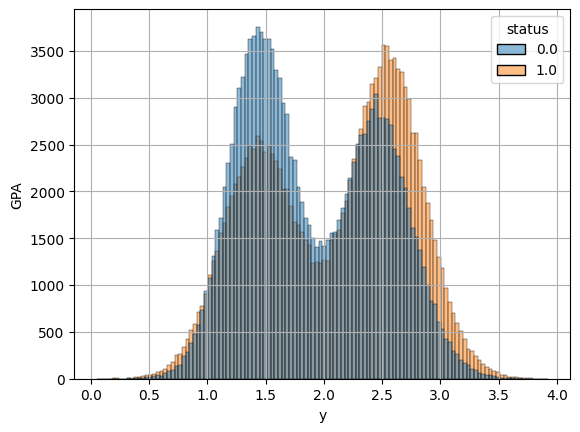

In [103]:
cmd =f'--num-applicants 300000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours_vseq'

args = script.get_args(cmd)
np.random.seed(1)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = script.generate_data(
    args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args
    )

df0 = pd.DataFrame(
    {'b1': b[disadv_idx,0], 'b2': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     'x1': x[disadv_idx,0], 'x2': x[disadv_idx,1]},
)
df1 = pd.DataFrame(
    {'b1': b[adv_idx,0], 'b2': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx], 'x1': x[adv_idx, 0], 'x2': x[adv_idx, 1], 'y_hat': y_hat[0, disadv_idx]},
)
df0['class'] = 'disadv'
df1['class'] = 'adv'
df = pd.concat((df0, df1))

# SAT score
dflong = pd.melt(df, id_vars=('class'), value_vars=('b1', 'x1'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])

# four mean lines
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time=='b1')].score.mean(), color='b', linestyle='--')
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time=='x1')].score.mean(), color='y', linestyle='--')

ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time=='b1')].score.mean(), color='b', linestyle='--')
ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time=='x1')].score.mean(), color='y', linestyle='--')

# GPA
dflong = pd.melt(df, id_vars=('class'), value_vars=('b2', 'x2'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])

# four mean lines
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time=='b2')].score.mean(), color='b', linestyle='--')
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time=='x2')].score.mean(), color='y', linestyle='--')

ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time=='b2')].score.mean(), color='b', linestyle='--')
ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time=='x2')].score.mean(), color='y', linestyle='--')

# College GPA (the target)
fig,ax=plt.subplots()
plt.hist(y[0],  histtype='step', bins=50)
plt.hist(y[0][z==1],  histtype='step', color='g', bins=50)
plt.hist(y[0][z==0], histtype='step', color='r', bins=50)

dfa, dfr = pd.DataFrame({'y': y[0][z==1]}), pd
fig,ax=plt.subplots()
sns.histplot(df, x='y', hue='status', ax=ax)
ax.set_ylabel('GPA')
ax.grid()

# sns.histplot(df, x='y', ax=ax)

In [104]:
n_runs = 10
args = script.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(script.run_multi_env, args_list )

299it [00:07, 37.57it/s]
299it [00:08, 37.32it/s]
299it [00:08, 36.57it/s]
299it [00:08, 36.88it/s]
299it [00:08, 36.61it/s]
299it [00:08, 36.49it/s]
299it [00:08, 36.38it/s]
299it [00:08, 36.22it/s]
299it [00:08, 36.29it/s]
299it [00:08, 36.35it/s]


In [116]:
# save_runs('experiments', 'our-settings', runs, args)
# with open('experiments/f711f06/our-settings/results', 'rb') as f:
  # runs = pickle.load(f)
runs

[{'2sls_env0': [0.9298152271036392,
   0.03813925101251049,
   0.024613197128653765,
   0.04634296726794879,
   0.05824832362820654,
   0.20312828058818344,
   0.22012303703201266,
   0.1885832348809044,
   0.19334499330137642,
   0.16889695708653552,
   0.15671266452401791,
   0.15507832071815517,
   0.15218610043299302,
   0.2064655978344117,
   0.22502324833529155,
   0.1758687938022478,
   0.090575337123779,
   0.12160742117709057,
   0.1483092386046135,
   0.15862633192096937,
   0.15541056791814054,
   0.1542148045570016,
   0.15042860990563148,
   0.15416808402514015,
   0.1580555790699256,
   0.15672632393292737,
   0.15798653087794867,
   0.15426445748604223,
   0.14269882216432103,
   0.14411282148659083,
   0.14543013733721136,
   0.14407406169361203,
   0.14417814456054823,
   0.1475586274421024,
   0.152140722739282,
   0.14623151448400568,
   0.13892586332403198,
   0.14189856420445365,
   0.14370649446636757,
   0.12466538420510405,
   0.1100166592247619,
   0.1185332398

In [106]:
df = script.runs2df(runs)
# long format for plotting
value_vars = [f'{m}_env{e}' for m in args.methods for e in range(args.num_envs)]
dflong = pd.melt(df, id_vars='iterations', value_vars=value_vars, var_name='env', value_name='error')
dflong 
dflong['method'] = dflong.env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.env.apply(lambda x:x.split('_')[-1])
dflong['method'] = dflong['method'].astype('category')
dflong['method'] = dflong['method'].cat.rename_categories({'ours_vseq': 'Ours', 'ols': 'OLS', '2sls': '2SLS'})
dflong

,iterations,env,error,method
0,0,env0,0.170022,2SLS
1,1,env0,0.005948,2SLS
2,2,env0,0.024151,2SLS
3,3,env0,0.105895,2SLS
4,4,env0,0.123728,2SLS
...,...,...,...,...
8965,294,env0,0.002558,Ours
8966,295,env0,0.002558,Ours
8967,296,env0,0.002594,Ours
8968,297,env0,0.002594,Ours


Text(0.5, 0, 'number of rounds')

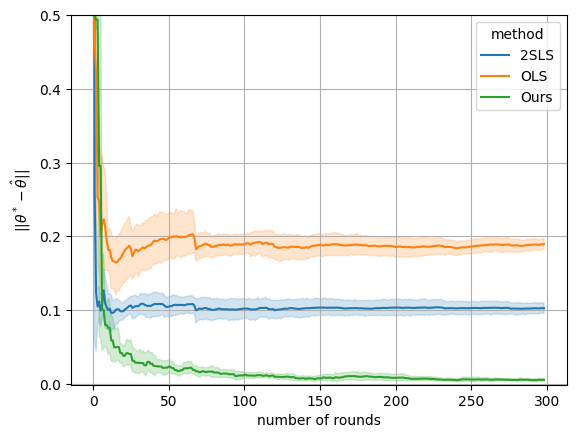

In [107]:
# dflong = pd.melt(df, id_vars='iterations', value_vars=('ours_env0', 'ours_env1'), var_name='env', value_name='error')
fig,ax=plt.subplots()
sns.lineplot(dflong, x='iterations', y='error', errorbar=('ci', 95), ax=ax, hue='method')
ax.grid()
ax.set_ylim(bottom=-0.001, top=.5)
ax.set_ylabel(r'$|| \theta^* - \hat{\theta}|| $')
ax.set_xlabel('number of rounds')

## multiple envs.

In [109]:
cmd =f'--num-applicants 300000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours_vseq --num-envs 2'
args = script.get_args(cmd)

# np.random.seed(1)
# b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = script.generate_data(
    # args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args, _theta_star=0.5
    # )

# df0 = pd.DataFrame(
    # {'b1': b[disadv_idx,0], 'b2': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     # 'x1': x[disadv_idx,0], 'x2': x[disadv_idx,1]},
# )
# df1 = pd.DataFrame(
    # {'b1': b[adv_idx,0], 'b2': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx], 'x1': x[adv_idx, 0], 'x2': x[adv_idx, 1], 'y_hat': y_hat[0, disadv_idx]},
# )
# df0['class'] = 'disadv'
# df1['class'] = 'adv'
# df = pd.concat((df0, df1))

# # SAT score
# dflong = pd.melt(df, id_vars=('class'), value_vars=('b1', 'x1'), var_name='time', value_name='score')
# fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
# sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
# sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])

# # four mean lines
# ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time=='b1')].score.mean(), color='b', linestyle='--')
# ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time=='x1')].score.mean(), color='y', linestyle='--')

# ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time=='b1')].score.mean(), color='b', linestyle='--')
# ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time=='x1')].score.mean(), color='y', linestyle='--')

# # GPA
# dflong = pd.melt(df, id_vars=('class'), value_vars=('b2', 'x2'), var_name='time', value_name='score')
# fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
# sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
# sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])

# # four mean lines
# ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time=='b2')].score.mean(), color='b', linestyle='--')
# ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time=='x2')].score.mean(), color='y', linestyle='--')

# ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time=='b2')].score.mean(), color='b', linestyle='--')
# ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time=='x2')].score.mean(), color='y', linestyle='--')

# # College GPA (the target)
# fig,ax=plt.subplots()
# plt.hist(y[0],  histtype='step', bins=50)
# plt.hist(y[0][z==1],  histtype='step', color='g', bins=50)
# plt.hist(y[0][z==0], histtype='step', color='r', bins=50)

# dfa = pd.DataFrame({'y': y[0][z==1]})
# fig,ax=plt.subplots()
# sns.histplot(df, x='y', hue='status', ax=ax)
# ax.set_ylabel('GPA')
# ax.grid()

# # sns.histplot(df, x='y', ax=ax)

In [110]:
n_runs = 10
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(script.run_multi_env, args_list )

299it [00:06, 47.82it/s]
299it [00:06, 47.96it/s]
299it [00:06, 47.99it/s]
299it [00:06, 48.79it/s]
299it [00:06, 46.45it/s]
299it [00:06, 48.13it/s]
292it [00:06, 25.98it/s]
299it [00:06, 47.28it/s]
299it [00:06, 46.46it/s]
65it [00:00, 181.07it/s]
299it [00:06, 48.11it/s] 
284it [00:05, 25.57it/s]
299it [00:06, 47.95it/s]
299it [00:06, 47.78it/s]
299it [00:06, 48.22it/s]
299it [00:06, 47.89it/s]
299it [00:06, 47.40it/s]
299it [00:06, 47.65it/s]
299it [00:06, 47.70it/s]
299it [00:06, 47.04it/s]


In [115]:
# save_runs('experiments', 'multi-env-clone', runs, args)
# with open('experiments/f711f06/multi-env-clone/results', 'rb') as f:
  # runs = pickle.load(f)

In [112]:
df = script.runs2df(runs)
df
value_vars = [f'{m}_env{e}' for m in args.methods for e in range(args.num_envs)]
dflong = pd.melt(df, id_vars='iterations', value_vars=value_vars, var_name='env', value_name='error')
dflong['method'] = dflong.env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.env.apply(lambda x:x.split('_')[-1])
dflong

,iterations,env,error,method
0,0,env0,0.929815,2sls
1,1,env0,0.038139,2sls
2,2,env0,0.024613,2sls
3,3,env0,0.046343,2sls
4,4,env0,0.058248,2sls
...,...,...,...,...
17935,294,env1,0.025568,ours_vseq
17936,295,env1,0.025568,ours_vseq
17937,296,env1,0.024754,ours_vseq
17938,297,env1,0.024754,ours_vseq


Text(0.5, 0, 'number of rounds')

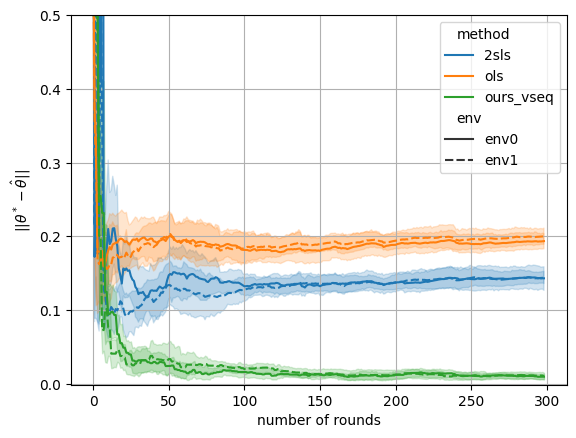

In [113]:
fig,ax=plt.subplots()
sns.lineplot(data=dflong, x='iterations', y='error', hue='method', style='env', errorbar=('ci', 95), ax=ax)
ax.grid()
ax.set_ylim(bottom=-.001, top=.5)
ax.set_ylabel(r'$ || \theta^* - \hat{\theta}|| $')
ax.set_xlabel('number of rounds')

## protocol vs. no protocol

In [ ]:
_runs = []
for protocol in (True, False):
    cmd = f'--num-applicants 300000 --applicants-per-round 1000 --fixed-effort-conversion --scaled-duplicates sequence --b-bias 2 --num-envs 2 --pref uniform --methods ours'
    if not protocol:
        cmd = f'{cmd} --no-protocol'
    print(cmd)
    
    args = script.get_args(cmd)
    n_runs = 10
    args_list = [(s, args, 0) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs = p.starmap(run_multi_exp, args_list )
        _runs.append(runs)

In [ ]:
df0 = runs2df(_runs[0])
df1 = runs2df(_runs[1])
df0['is-protocol'] = True
df1['is-protocol'] = False
df = pd.concat((df0, df1))
df

In [ ]:
fig,ax=plt.subplots()
sns.lineplot(data=df.reset_index(), x='iterations', y='ours_env0', hue='is-protocol')
ax.grid()
ax.set_ylim(bottom=-.001, top=.5)
ax.set_xlabel('number of rounds')
ax.set_ylabel(r'$ || \theta^* - \hat{\theta}|| $')

In [ ]:
from sklearn.linear_model import LinearRegression

cmd =f'--num-applicants 10000 --applicants-per-round 100 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours 2sls ols'
args = script.get_args(cmd)
np.random.seed(1)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = script.generate_data(
    args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args, _theta_star=0.5
    )


def our_vseq(x, y, w, applicants_per_round):
    assert x.ndim == 2
    n_applicants = x.shape[0]
  
    idx1, idx2, idx3 = 0, 0, 0
  
    A, b = [], []
    for t in range(0, n_applicants, applicants_per_round*2):
      w_t1 = w[t:t+applicants_per_round]
      w_t2 = w[t+applicants_per_round:t+applicants_per_round+applicants_per_round]

      x_t1 = x[t:t+applicants_per_round][w_t1 == 1]
      x_t2 = x[t+applicants_per_round:t+applicants_per_round+applicants_per_round][w_t2 == 1]

      idx2 = int(idx1 + w_t1.sum())
      idx3 = int(idx2 + w_t2.sum())

      y_t1 = y[idx1:idx2]
      y_t2 = y[idx2:idx3]

      b.append(y_t2.mean() - y_t1.mean())
      A.append(
    x_t1.mean(axis=0, keepdims=True) - x_t2.mean(axis=0, keepdims=True)
  )

      idx1 = idx3
  
    assert idx1 == y.size, f'{idx1}, {y.size}'
    A , b= np.concatenate(A, axis=0), np.concatenate(b)
  
    m = LinearRegression()
    m.fit(A, b)

our_vseq(args, x, y, w)

In [ ]:
np.random.normal(loc=5, scale=0, size=(100,))

In [ ]:
test = np.random.normal(size=(1000, 3, 2))

In [ ]:
np.transpose(test, axes=(0, 2, 1)).shape